In [47]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from lion_pytorch import Lion

from src.features import build_features_op, utils, build_features_optim, build_features, build_features_optimizer
from src.models import predict_model
from src.train.train import train, evaluation, prediction_to_csv
from src.data.make_dataset import DatasetLoader
from src.config.config import seed_everything, cfg
from src.visualization.visual import plot_label_counts

warnings.filterwarnings(action='ignore')
seed_everything(cfg.SEED)

scaler = MinMaxScaler()

drop_feature = ['type', 'motor_hp']

# 데이터 전처리
train_data = pd.read_csv(r'data\raw\train_data.csv')
# train_data = utils.outlier_z_score_filter_df(train_data)
train_data = build_features.create_derived_features(train_data)
train_data = train_data.drop(drop_feature, axis=1)

test_data = pd.read_csv(r'data\raw\test_data.csv')
test_data = build_features.create_derived_features(test_data)
test_data = test_data.drop(drop_feature, axis=1)
test_data_raw = test_data.copy()

scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

scaled_train_data_df = pd.DataFrame(scaled_train_data, columns=train_data.columns)
scaled_test_data_df = pd.DataFrame(scaled_test_data, columns=train_data.columns)

n_features = scaled_train_data.shape[1]
print(n_features)

scaled_train_data = scaled_train_data_df.values
scaled_test_data = scaled_test_data_df.values

# 데이터 로더
dataloader = DatasetLoader(scaled_train_data, scaled_test_data)
train_loader, test_loader = dataloader.load

# 학습 파라미터
model = predict_model.SingleAutoEncoder(input_dim=n_features, hidden_dim=512)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# optimizer = Lion(model.parameters(), lr=cfg.LEARNING_RATE)

# 학습
train(train_loader, model, criterion, optimizer)

# 예측
train_prediction, train_cosine = evaluation(train_loader, model)
print(min(train_cosine))
prediction, test_cosine = evaluation(test_loader, model, min(train_cosine))

# 제출
submission = prediction_to_csv(prediction)


30
Epoch [0/2000], Loss: 0.2084727
Epoch [100/2000], Loss: 0.0009943
Epoch [200/2000], Loss: 0.0001962
Epoch [300/2000], Loss: 0.0000818
Epoch [400/2000], Loss: 0.0000364
Epoch [500/2000], Loss: 0.0000198
Epoch [600/2000], Loss: 0.0000156
Epoch [700/2000], Loss: 0.0000091
Epoch [800/2000], Loss: 0.0000089
Epoch [900/2000], Loss: 0.0000077
Epoch [1000/2000], Loss: 0.0000063
Epoch [1100/2000], Loss: 0.0000044
Epoch [1200/2000], Loss: 0.0000041
Epoch [1300/2000], Loss: 0.0000036
Epoch [1400/2000], Loss: 0.0000043
Epoch [1500/2000], Loss: 0.0000033
Epoch [1600/2000], Loss: 0.0000036
Epoch [1700/2000], Loss: 0.0000029
Epoch [1800/2000], Loss: 0.0000028
Epoch [1900/2000], Loss: 0.0000026
0.9997433423995972
label
0    7045
1     344
Name: count, dtype: int64


---
Classification

In [89]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler # Tree-structured Parzen Estimator algorithm
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [81]:
scaled_test_data_df['label'] = prediction
scaled_train_data_df['label'] = train_prediction
cls_data = pd.concat([scaled_train_data_df, scaled_test_data_df], axis=0)

x_train = cls_data.drop('label', axis=1)
y_train = cls_data['label']

In [85]:
x_test = scaled_test_data_df.drop('label', axis=1)

In [90]:
# 1. Define an objective function to be maximized.
def objective_xgb(trial: Trial, x, y):


# 2. Suggest values for the hyperparameters using a trial object
    param = {
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        'max_depth': trial.suggest_int('max_depth', 8, 16),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_int('gamma', 1, 3),
        'learning_rate': 0.01,
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'random_state': 42
    }

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

    model = XGBClassifier(**param, tree_method='gpu_hist', gpu_id=0)
    xgb_model = model.fit(x_train, y_train, verbose=False, eval_set=[(x_val, y_val)])
    score = f1_score(xgb_model.predict(x_val), y_val, average='macro')

    return score

study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(lambda trial: objective_xgb(trial, x_train, y_train), n_trials=100)
print('Best trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2023-04-14 16:16:07,216] A new study created in memory with name: no-name-bed3c3d9-60f3-42a9-ade3-8394d5be52f4
[I 2023-04-14 16:16:07,999] Trial 0 finished with value: 0.49017071908949816 and parameters: {'n_estimators': 569, 'max_depth': 9, 'min_child_weight': 256, 'gamma': 3, 'lambda': 0.0019125176975567644, 'alpha': 0.00978835483595627, 'subsample': 0.8}. Best is trial 0 with value: 0.49017071908949816.
[I 2023-04-14 16:16:10,302] Trial 1 finished with value: 0.9799645033209522 and parameters: {'n_estimators': 1269, 'max_depth': 14, 'min_child_weight': 20, 'gamma': 2, 'lambda': 0.8549651279568675, 'alpha': 1.436203049054979, 'subsample': 0.8}. Best is trial 1 with value: 0.9799645033209522.
[I 2023-04-14 16:16:15,245] Trial 2 finished with value: 0.49174832387828776 and parameters: {'n_estimators': 3528, 'max_depth': 9, 'min_child_weight': 156, 'gamma': 2, 'lambda': 0.18526785694767864, 'alpha': 6.827520922988961, 'subsample': 0.7}. Best is trial 1 with value: 0.9799645033209522.

Best trial: score 0.9966421629172807,
params {'n_estimators': 1883, 'max_depth': 14, 'min_child_weight': 2, 'gamma': 2, 'lambda': 2.3456811220938243, 'alpha': 0.8665324516254036, 'subsample': 0.7}


In [93]:
params = study.best_trial.params
xgb_model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0).fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

In [95]:
submission = prediction_to_csv(y_pred)


label
0    7056
1     333
Name: count, dtype: int64


---

In [44]:
test_data['label'] = prediction
test_data['treshold'] = test_cosine
def no_out(test_data):
    test7342 = test_data[7342:7361]
    no = test7342[test7342['label']==1]
    yes = test7342[test7342['label']==0]
    return yes, no

yes, no = no_out(test_data)

In [37]:
def plot_label_counts(predictions, chunk_sizes):
    for i, (start, end) in enumerate(chunk_sizes):
        chunk = predictions[start:end]
        num_labels = len(chunk[chunk['label'] == 1])
        print(f"Chunk {i}: {num_labels} labels with value 1")
        plt.plot(chunk['label'])
        plt.show()

Chunk 0: 143 labels with value 1


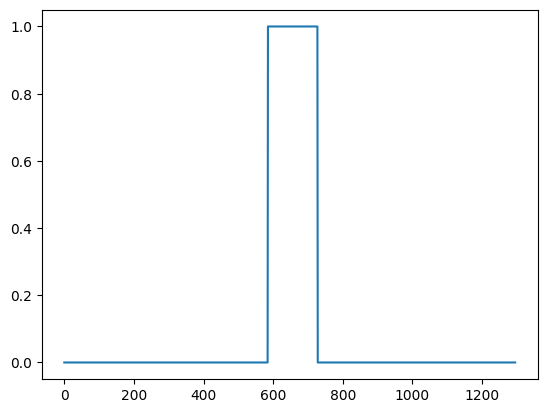

Chunk 1: 0 labels with value 1


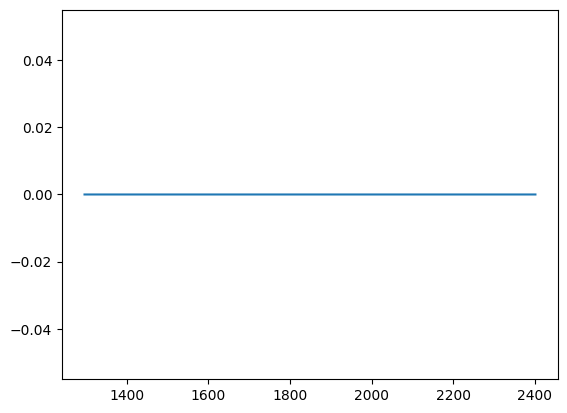

Chunk 2: 21 labels with value 1


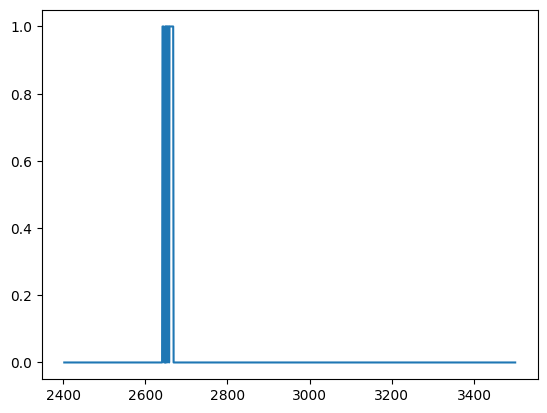

Chunk 3: 25 labels with value 1


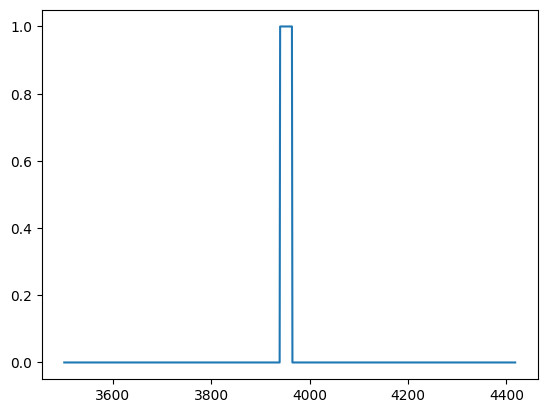

Chunk 4: 9 labels with value 1


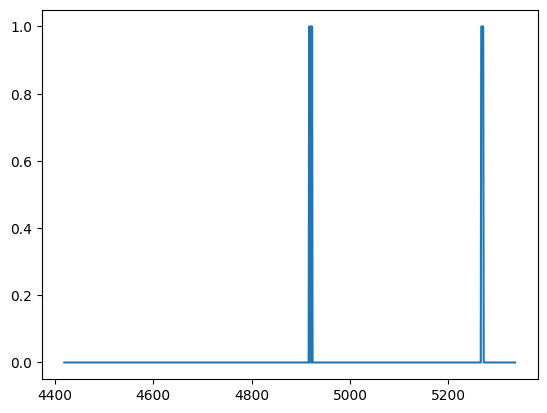

Chunk 5: 29 labels with value 1


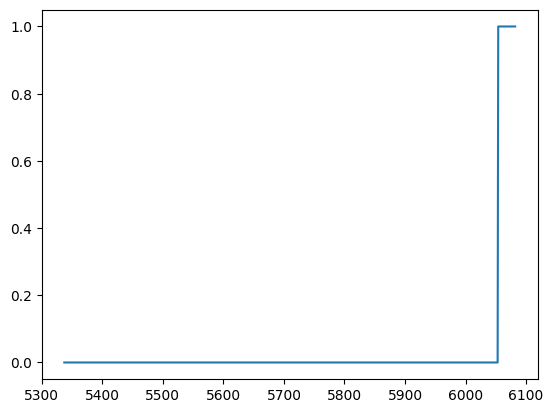

Chunk 6: 102 labels with value 1


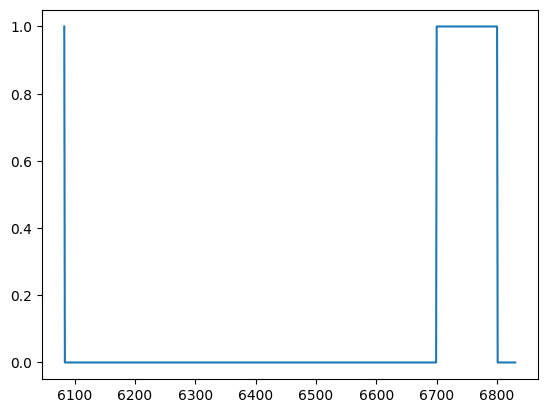

Chunk 7: 4 labels with value 1


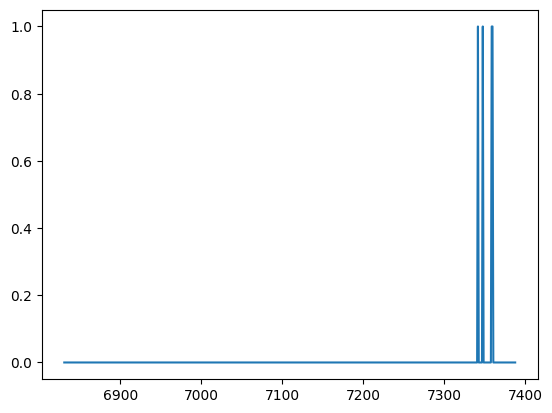

In [97]:
ranges = [(0, 1296), (1296, 2403), (2403, 3501), (3501, 4419), (4419, 5337), (5337, 6083), (6083, 6831), (6831, len(prediction))]
plot_label_counts(submission, ranges)

In [15]:
train_data['label'] = train_cosine

In [9]:
x_train = train_data.drop('label', axis=1)
y_train = train_data['label']

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(test_data)

In [72]:
test_data['label'] = y_pred

In [75]:
test_data[test_data['label']>0.7]

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,pressure_flow_ratio,vibe_voltage_ratio,performance_index,pressure_load_ratio,vibe_rpm_ratio,vibe+rpm_temp,temp_diff,rpm*inflow,label
0,2.5100,53.2800,0.7000,32.5400,2662.0000,69.5800,3.4800,0.2789,0.1069,0.0008,0.6454,764.9425,38.3081,16.3000,3.4809,0.9999
1,2.6600,55.2400,0.7000,34.4500,2819.0000,71.3200,3.5700,0.2632,0.1036,0.0008,0.6096,789.6359,39.5761,16.0800,3.5709,0.9999
2,1.7200,42.7400,0.7000,22.2300,1819.0000,60.2100,3.0100,0.4070,0.1354,0.0009,0.9447,604.3189,30.2609,17.4700,3.0109,0.9998
3,2.2000,49.1500,0.7000,28.5000,2332.0000,65.9100,3.3000,0.3182,0.1158,0.0008,0.7368,706.6667,35.4316,16.7600,3.3009,0.9999
4,2.0600,47.2800,0.7000,26.6700,2182.0000,64.2400,3.2100,0.3398,0.1204,0.0008,0.7874,679.7508,34.0163,16.9600,3.2109,0.9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7384,2.1200,48.0800,0.7000,27.4500,2246.0000,64.9600,3.2500,0.3302,0.1184,0.0008,0.7650,691.0769,34.6252,16.8800,3.2509,0.9999
7385,1.4800,39.6300,0.7000,19.1900,1570.0000,57.4400,2.8700,0.4730,0.1496,0.0009,1.0943,547.0383,27.3828,17.8100,2.8709,0.9999
7386,1.5600,40.6100,0.7000,20.1500,1649.0000,58.3200,2.9200,0.4487,0.1449,0.0009,1.0422,564.7260,28.3251,17.7100,2.9209,0.9998
7387,1.5900,40.9900,0.7000,20.5200,1679.0000,58.6600,2.9300,0.4403,0.1428,0.0009,1.0234,573.0375,28.6725,17.6700,2.9309,0.9998


(array([1.000e+00, 0.000e+00, 2.000e+00, 5.000e+00, 0.000e+00, 6.000e+00,
        3.000e+01, 1.400e+01, 3.000e+00, 7.328e+03]),
 array([0.9966175 , 0.9969456 , 0.9972738 , 0.997602  , 0.9979301 ,
        0.99825823, 0.9985864 , 0.9989146 , 0.9992427 , 0.99957085,
        0.999899  ], dtype=float32),
 <BarContainer object of 10 artists>)

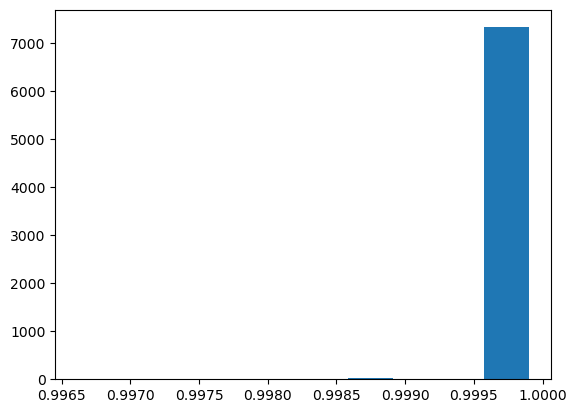

In [74]:
plt.hist(test_data.label)